# Welcome

This notebook demonstrates the vocoding process using these vocoders:
1. HiFi-GAN
2. Hn-sinc-NSF
3. Hn-sinc-NSF + HiFi-GAN discriminator
4. WaveGlow

Several pre-trained versions are available. They differ in terms of the vocoder's training data"
1. VoxCeleb2 dev set
2. LibriTTS subset (16kHz)
3. ASVspoof 2019 bona fide trn set
4. LibriTTS subset (16kHz) then ASVspoof 2019 bona fide trn set
5. MLS English part, subset of 200h

Versions 2-4 were used to prepare the databases *voc.v2*, *voc.v3*, *voc.v4* in this paper:
```bibtex
Xin Wang, and Junichi Yamagishi. Spoofed training data for speech spoofing countermeasure can be efficiently created using neural vocoders. Proc. ICASSP, 2023 (to appear)
```

**Links**:
* Click this Colab badge to go back to tutorials on neural vocoders [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1EO-ggi1U9f2zXwTiqg7AEljVx11JKta7?usp=sharing)
* Git repo behind this project:  https://github.com/nii-yamagishilab/project-NN-Pytorch-scripts


**Notes**:
1. Please check LICENSE section for information on license.
2. To protect the privacy of the speakers in VoxCeleb2, input audio samples from VoxCeleb2 database in this notebook have been anonymized using the DSP-based method from [VPC 2022 tutorial (section 2.2)](https://colab.research.google.com/drive/1_zRL_f9iyDvl_5Y2Rdakg0hYAl_5Rgyq?usp=sharing).
    * Audio samples here are only for **demonstration purpose**.
    * They sound artificial (even before vocoding)
    * Please try to do vocoding on the original VoxCeleb2 samples by yourself. It sounds much better.
3. This notebook by default uses CPU for demonstration.
4. This notebook extracts the minimum code from my github repo. If you want to try model training, please check the scripts and codes in [this project](https://github.com/nii-yamagishilab/project-NN-Pytorch-scripts/blob/master/project/01-nsf) and [this project](https://github.com/nii-yamagishilab/project-NN-Pytorch-scripts/blob/master/project/05-nn-vocoders) on github.

5. Only a single audio sample will be vocoded (copy-synthesized) in this notebook. To process multiple waveforms, you may download the scripts and follow the `README.txt` there

```sh
mkdir NNvocoders_pretrained; cd NNvocoders_pretrained

wget --quiet --show-progress -O NNvocoders_pretrained.zip https://www.dropbox.com/sh/bua2vks8clnl2ha/AAAk17GyfzfE2S3CZJ6333aga/NNvocoders

unzip NNvocoders_pretrained.zip
```

Please contact [Xin Wang](http://tonywangx.github.io/) for any questions.

# Preparation

We will download the pre-trained vocoders and the code.

All the codes in this notebook are based on Python / Pytorch.

The Python dependency consits of two parts:
1. Those specified in https://github.com/nii-yamagishilab/project-NN-Pytorch-scripts/blob/master/env.yml. This has been pre-installed in the default Google Colab environment. No need to install them on Google Colab. However, if you run the code on your server, please install the dependency.

2. Python tools in https://github.com/nii-yamagishilab/project-NN-Pytorch-scripts

2. Some external tools such as Pyworld.



In [ ]:
!echo "Install dependency"
# part 1: install Pytorch dependecy
# See https://github.com/nii-yamagishilab/project-NN-Pytorch-scripts/blob/master/env.yml
# It has been included in Google Colab environment. Do nothing
!git clone --depth 1 https://github.com/nii-yamagishilab/project-NN-Pytorch-scripts.git
#!conda env create -f env.yml

# part 2: install pyworld
# other F0 estimator is also OK. We use pyworld for convenience
!pip install pyworld

Install dependency
Cloning into 'project-NN-Pytorch-scripts'...
remote: Enumerating objects: 741, done.
remote: Counting objects: 100% (741/741), done.
remote: Compressing objects: 100% (386/386), done.
remote: Total 741 (delta 367), reused 589 (delta 325), pack-reused 0
Receiving objects: 100% (741/741), 10.58 MiB | 17.01 MiB/s, done.
Resolving deltas: 100% (367/367), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 KB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyworld: filename=pyworld-0.3.2-cp38-cp38-linux_x86_64.whl size=919614 sha256=8600cf612762113819eac3373543edeb54c88cc9fa4c4b64a4d148a5ca81d76e
  Stored in directory: /root/.cache/pip/wheels/b7/b1/d2/8c78d691f7d5b0bb4ba9993926db209429c92686476837627f
Successfully built pyworld


In [ ]:
!echo "Download pre-trained models, code, and sample data"
!wget --quiet --show-progress -O NNvocoders_pretrained.zip https://www.dropbox.com/sh/bua2vks8clnl2ha/AAAk17GyfzfE2S3CZJ6333aga/NNvocoders
!echo "Unzip files"
!unzip -q -o NNvocoders_pretrained.zip -x / -d /content
!if [ -d "/content/pretrained-voxceleb2" ]; then echo "Done"; else echo "Please contact with the author"; fi

Download pre-trained models, code, and sample data
NNvocoders_pretrain 100%[===================>]   1.90G  42.4MB/s    in 45s     
Unzip files
Please contact with the author


In [ ]:
# Add the downloaded github repo to PYTHONPATH
import sys
sys.path.insert(1, "/content/project-NN-Pytorch-scripts")

# Copy-synthesis

## Configuration

The pre-trained vocoders use the follow configurations for the input acoustic features and waveforms. Don't change them.

In [ ]:
# configurations fixed and used by the pre-trained models
# Don't change these settings

# sampling rate
wav_sampling_rate = 16000
# acoustic feature upsampling rate,
# this is equal to wav_sampling_rate * frame_shift
# here we use 10ms shift, thu 10ms * 16 kHz = 160
feat_upsampling_rate = 160
# FFT size for mel-spectra extraction
feat_mel_fft_size = 1024
# Frame length for Mel-spectra extraction
feat_mel_frame_length = 400
# Frame length for Pyworld (in ms), here is 10ms
feat_f0_frame_period = feat_upsampling_rate * 1000 // wav_sampling_rate

# input feature dimension of F0 and Mel (per frame)
input_f0_dim = 1
input_mel_dim = 80
# output dimension = 1 for waveform
output_dim = 1

Specify the input waveform to be copy-synthesized

Specify which pre-trained version you want to use

In [ ]:
!find ./data -type f -name "*.wav"

./data/voxceleb2/dev/id00015/XvqWxjZySuA/00280.wav
./data/voxceleb2/dev/id00015/XvqWxjZySuA/00278.wav
./data/voxceleb2/dev/id00015/XvqWxjZySuA/00279.wav
./data/voxceleb2/dev/id00015/XvqWxjZySuA/00281.wav
./data/voxceleb2/dev/id00012/2DLq_Kkc1r8/00016.wav
./data/voxceleb2/dev/id00012/2DLq_Kkc1r8/00018.wav
./data/voxceleb2/dev/id00012/2DLq_Kkc1r8/00017.wav
./data/asvspoof19_bona/trn/LA_T_2217523.wav
./data/asvspoof19_bona/trn/LA_T_9174733.wav
./data/asvspoof19_bona/trn/LA_T_1794966.wav
./data/asvspoof19_bona/trn/LA_T_6642565.wav
./data/asvspoof19_bona/trn/LA_T_7244018.wav
./data/asvspoof19_bona/trn/LA_T_5872241.wav
./data/asvspoof19_bona/trn/LA_T_6936229.wav
./data/asvspoof19_bona/trn/LA_T_1447757.wav
./data/asvspoof19_bona/trn/LA_T_5322386.wav
./data/asvspoof19_bona/trn/LA_T_9234278.wav
./data/asvspoof19_bona/trn/LA_T_6601259.wav
./data/asvspoof19_bona/trn/LA_T_7087021.wav


In [ ]:
# path to the input waveform (.wav format)
# Or you may try any wavform included in the downloaded package
input_wav_path = './data/asvspoof19_bona/trn/LA_T_1794966.wav'


In [ ]:
# Which version to be used?
#
#
# 1. pretrained_voxceleb2: VoxCeleb2 dev set
# 2. pretrained_libritts_subset: LibriTTS subset (16kHz)
# 3. pretrained_asvspoof_trn_bona: ASVspoof 2019 bona fide trn set
# 4. pretrained_libritts_asvspoof_trn_bona: LibriTTS subset (16kHz) then ASVspoof 2019 bona fide trn set
# 5, pretrained_mls_en_subset: MLS English part, a randomly selected 200 hsubset
#
# Versions 2-4 correspond to *voc.v2*, *voc.v3*, *voc.v4* in ICASSP paper


pretrained_version = 'pretrained_voxceleb2' #@param ["pretrained_voxceleb2", "pretrained_libritts_subset", "pretrained_libritts_asvspoof_trn_bona", "pretrained_asvspoof_trn_bona", "pretrained_mls_en_subset"]

In [ ]:
# By default
# in this notebook, we will use cpu to synthesize the waveform
device_name = 'cpu'


## Feature extraction

Extract Mel-spectra and F0 (for some of the vocoders).

In [ ]:
import os
import sys
import pyworld as pw
import numpy as np
from core_scripts.data_io import io_tools
from core_scripts.data_io import wav_tools
from core_scripts.data_io import dsp_tools


In [ ]:
def extract_f0(wav_data, sr=wav_sampling_rate, frame_period=feat_f0_frame_period):
    """f0 = extract_f0(wav_data, sr, frame_period)

    input: wav_data, np.array, in shape (length, 1), waveform data
    input: sr, int, sampling rate in Hz
    input: frame_period, float, frame length in ms
    output: f0, np.array, in shape (length, 1), f0 dat
    """
    x = np.array(wav_data, dtype=np.float64)


    _f0, t = pw.dio(x, sr, frame_period=frame_period)
    f0 = pw.stonemask(x, _f0, t, sr)  # pitch refinement
    return np.array(f0, dtype=np.float32)

g_mel_extractor = dsp_tools.Melspec(sf=wav_sampling_rate,
                                    fftl=feat_mel_fft_size,
                                    fl=feat_mel_frame_length,
                                    fs=feat_upsampling_rate,
                                    ver=2)
def extract_mel(wav_data, mel_extractor=g_mel_extractor):
    """mel_spec = extract_mel(wav_data, mel_extractor)

    input: wav_data, np.array, in shape (length, 1), waveform data
    input: mel_extractor, mel-spectra extractor
    output: mel_spec, np.array, in shape (length, dim), mel-spectra data
    """
    return mel_extractor.analyze(wav_data)


def extract_mel_f0_core(f_mel_extractor, f_f0_extractor, input_wav):
    """mel, f0 = extract_mel_f0_core(f_mel_extractor, f_f0_extractor, input_wav)

    This function calls f_mel_extractor and f_f0_extractor to extract Mel-spectra
    and F0 from input wav.

    input: f_mel_extractor, Mel-spectra extractor
    input: f_f0_extractor, F0 extractor,
    input: wav_data, np.array, in shape (length, 1), waveform data
    output: mel_spec, np.array, in shape (length, dim), mel-spectra data
    output: f0, np.array, in shape (length, 1), f0 dat
    """
    # extract mel or other spectral featues
    mel = f_mel_extractor(input_wav)
    # f0
    f0 = f_f0_extractor(input_wav)

    # change shape of F0 data and assign 0 to unvoiced frames
    if f0.ndim > 1:
        f0 = f0[:, 0]
    f0[np.isnan(f0)] = 0

    # adjust length (number of frames) of two features
    mel_frame = mel.shape[0]
    if f0.shape[0] < mel_frame:
        f0 = np.concatenate(
            [f0, np.zeros([mel.shape[0] - f0.shape[0]])], axis=0)
    else:
        f0 = f0[:mel_frame]
    return mel, f0


In [ ]:
# Load waveform
sr, input_wav = wav_tools.waveReadAsFloat(input_wav_path)

# Extract Mel-spectra and F0
mel, f0 = extract_mel_f0_core(lambda x: extract_mel(x),
                              lambda x: extract_f0(x),
                              input_wav)

assert input_mel_dim == mel.shape[1], "FAIL to extract valid Mel spectrogram"

(321, 80)
(321,)
Cannot find tex or latex. matplotlib.rc usetex is disabled


(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:xlabel='frame index', ylabel='F0 value (Hz)'>)

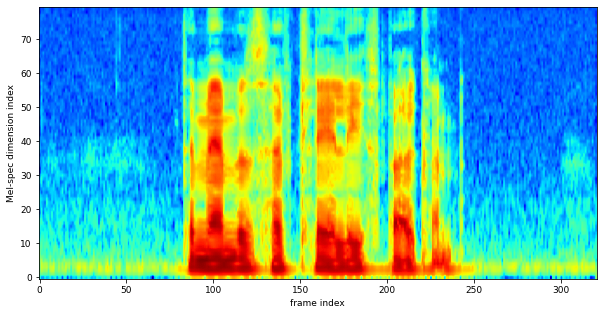

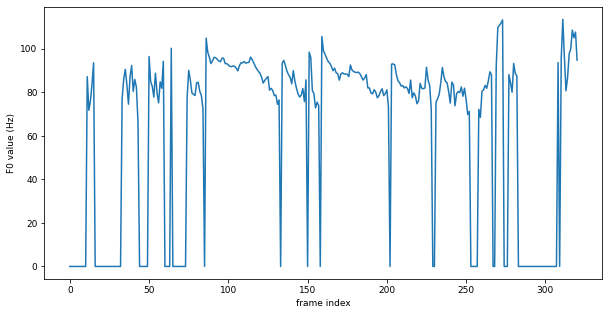

In [ ]:
# visualization
print(mel.shape)
print(f0.shape)
from tutorials.plot_tools import plot_API
from tutorials.plot_tools import plot_lib
plot_API.plot_API(mel.T, plot_lib.plot_imshow, 'single',
                  {'xlabel': "frame index", 'ylabel': 'Mel-spec dimension index'})
plot_API.plot_API(f0, plot_lib.plot_signal, 'single',
                  {'xlabel': "frame index", 'ylabel': 'F0 value (Hz)'})

As you can see, Pyworld has falsely detected F0 in many frames.

**This is the reason that NSF samples sound buzzy in unvoiced regions**.


You may plug in another F0 estimator. We use Pyworld for demonstration because it is fast.


## Copy-Synthesis

We can do copy-synthesis using the extracted Mel-spectra and F0.



### Claim models

In [ ]:
# This is the configuration in config.py
# For convenience, put it here
# Don't change these settings
class PrjConfig_hifigan:
    def __init__(self, wav_samp_rate, feat_upsamp_rate):
        self.input_dim = input_mel_dim
        self.output_dim = output_dim
        self.wav_samp_rate = wav_samp_rate
        self.input_reso = [feat_upsamp_rate]
        self.options = {'hifigan_config':
           {
               'upsample_rates': [8, 5, 2, 2],
               'upsample_kernel_sizes': [16, 9, 4, 4],
               'upsample_initial_channel': 512,
               'resblock_kernel_sizes': [3, 7, 11],
               'resblock_dilation_sizes': [[1, 3, 5], [1, 3, 5], [1, 3, 5]]
           }}
        return


class PrjConfig_hn_sinc_nsf:
    def __init__(self, wav_samp_rate, feat_upsamp_rate):
        self.input_dim = input_mel_dim + input_f0_dim
        self.output_dim = output_dim
        self.wav_samp_rate = wav_samp_rate
        self.input_reso = [feat_upsamp_rate]
        return

class PrjConfig_hn_sinc_nsf_hifi:
    def __init__(self, wav_samp_rate, feat_upsamp_rate):
        self.input_dim = input_mel_dim + input_f0_dim
        self.output_dim = output_dim
        self.wav_samp_rate = wav_samp_rate
        self.input_reso = [feat_upsamp_rate]
        return

class PrjConfig_waveglow:
    def __init__(self, wav_samp_rate, feat_upsamp_rate):
        self.input_dim = input_mel_dim
        self.output_dim = output_dim
        self.wav_samp_rate = wav_samp_rate
        self.input_reso = [feat_upsamp_rate]
        return

In [ ]:
# path to the pre-trained models
#
vocoder_pretrained_path = {
    'hifigan': './{:s}/hifigan/trained_network_G.pt'.format(pretrained_version),
    'hn_sinc_nsf': './{:s}/hn_sinc_nsf/trained_network.pt'.format(pretrained_version),
    'hn_sinc_nsf_hifi': './{:s}/hn_sinc_nsf_hifi/trained_network_G.pt'.format(pretrained_version),
    'waveglow': './{:s}/waveglow/trained_network.pt'.format(pretrained_version)
    }

# configuration files
vocoder_config = {
    'hifigan': PrjConfig_hifigan(wav_sampling_rate, feat_upsampling_rate),
    'hn_sinc_nsf': PrjConfig_hn_sinc_nsf(wav_sampling_rate, feat_upsampling_rate),
    'hn_sinc_nsf_hifi': PrjConfig_hn_sinc_nsf_hifi(wav_sampling_rate, feat_upsampling_rate),
    'waveglow': PrjConfig_waveglow(wav_sampling_rate, feat_upsampling_rate),
    }

### HiFiGAN

In [ ]:
model_config = vocoder_config['hifigan']
pretrained_path = vocoder_pretrained_path['hifigan']
from pretrained_voxceleb2.hifigan import model as hifigan
m_vocoder = hifigan.ModelGenerator(model_config.input_dim, model_config.output_dim, None, model_config)

In [ ]:
# load the per-trained HiFiGAN-NSF model
import torch

# put to device
device=torch.device(device_name)
m_vocoder.to(device, dtype=torch.float32)

# load pretrained model
checkpoint = torch.load(pretrained_path, map_location=device_name)
m_vocoder.load_state_dict(checkpoint)
m_vocoder.eval();

In [ ]:
# cast into tensor (batch, frame_num, dim)
input_feat = torch.tensor(mel, dtype=torch.float32, device=device).unsqueeze(0)

# synthesize
with torch.no_grad():
    output = m_vocoder(input_feat)
    hifigan_vocoded_wav = output[0, :, 0].numpy()

Removing weight norm...


### Hn-sinc-nsf

In [ ]:
model_config = vocoder_config['hn_sinc_nsf']
pretrained_path = vocoder_pretrained_path['hn_sinc_nsf']
from pretrained_voxceleb2.hn_sinc_nsf import model as hn_sinc_nsf
m_vocoder = hn_sinc_nsf.Model(model_config.input_dim, model_config.output_dim, None, model_config)

In [ ]:
# put to device
device=torch.device(device_name)
m_vocoder.to(device, dtype=torch.float32)

# load pretrained model
checkpoint = torch.load(pretrained_path, map_location=device_name)
m_vocoder.load_state_dict(checkpoint)
m_vocoder.eval();

In [ ]:
# cast into tensor (batch, frame_num, dim)
input_feat = torch.tensor(np.concatenate([mel, np.expand_dims(f0, axis=1)], axis=1),
                          dtype=torch.float32, device=device).unsqueeze(0)

# synthesize

with torch.no_grad():
    output = m_vocoder(input_feat)
    hn_sinc_nsf_vocoded_wav = output[0].numpy()

### Hn-sinc-nsf-hifi

In [ ]:
model_config = vocoder_config['hn_sinc_nsf_hifi']
pretrained_path = vocoder_pretrained_path['hn_sinc_nsf_hifi']
from pretrained_voxceleb2.hn_sinc_nsf_hifi import model as hn_sinc_nsf_hifi
m_vocoder = hn_sinc_nsf_hifi.ModelGenerator(model_config.input_dim, model_config.output_dim, None, model_config)

In [ ]:
# put to device
device=torch.device(device_name)
m_vocoder.to(device, dtype=torch.float32)

# load pretrained model
checkpoint = torch.load(pretrained_path, map_location=device_name)
m_vocoder.load_state_dict(checkpoint)
m_vocoder.eval();

In [ ]:
# cast into tensor (batch, frame_num, dim)
input_feat = torch.tensor(np.concatenate([mel, np.expand_dims(f0, axis=1)], axis=1),
                          dtype=torch.float32, device=device).unsqueeze(0)

# synthesize
with torch.no_grad():
    output = m_vocoder(input_feat)
    hn_sinc_nsf_hifi_vocoded_wav = output[0, :, 0].numpy()

### WaveGlow

In [ ]:
model_config = vocoder_config['waveglow']
pretrained_path = vocoder_pretrained_path['waveglow']
from pretrained_voxceleb2.waveglow import model as waveglow
m_vocoder = waveglow.Model(model_config.input_dim, model_config.output_dim, None, model_config)

/content/project-NN-Pytorch-scripts/sandbox/block_waveglow.py:32: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2349.)
  W = torch.qr(torch.FloatTensor(feat_dim, feat_dim).normal_())[0]


In [ ]:
# put to device
device=torch.device(device_name)
m_vocoder.to(device, dtype=torch.float32)

# load pretrained model
checkpoint = torch.load(pretrained_path, map_location=device_name)
m_vocoder.load_state_dict(checkpoint)
m_vocoder.eval();

In [ ]:
# cast into tensor (batch, frame_num, dim)
input_feat = torch.tensor(mel, dtype=torch.float32, device=device).unsqueeze(0)

# synthesize
# (it will take 20s on CPU. GPU will be faster)

with torch.no_grad():
    output = m_vocoder.inference(input_feat)
    waveglow_vocoded_wav = output[0, :, 0].numpy()

## Check the audio

'Original waveform'

'HiFiGAN vocoded waveform (pretrained_voxceleb2)'

'Hn-sinc-NSF vocoded waveform (pretrained_voxceleb2)'

'Hn-sinc-NSF-HiFiGAN vocoded waveform (pretrained_voxceleb2)'

'WaveGlow vocoded waveform (pretrained_voxceleb2)'

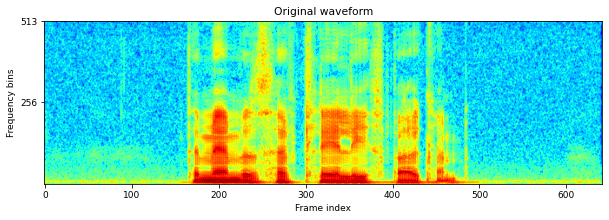

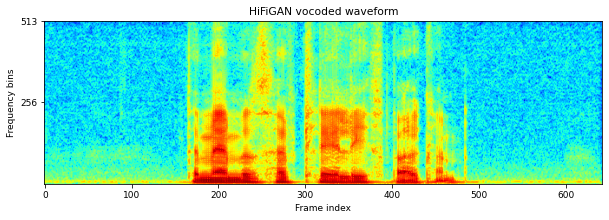

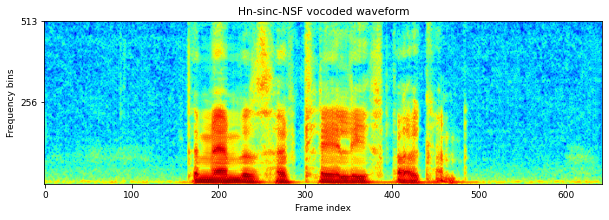

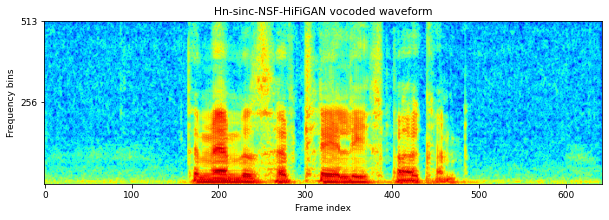

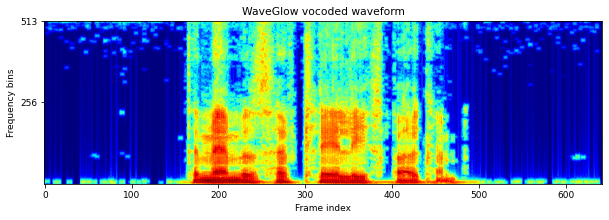

In [ ]:
# Listen to the waveforms

import IPython.display
from tutorials.plot_tools import plot_API
from tutorials.plot_tools import plot_lib

IPython.display.display("Original waveform")
IPython.display.display(IPython.display.Audio(input_wav, rate=wav_sampling_rate))
plot_API.plot_API(input_wav, plot_lib.plot_spec, 'single' ,
                  {'figsize': (10, 3), 'title': "Original waveform"});

IPython.display.display("HiFiGAN vocoded waveform ({:s})".format(pretrained_version))
IPython.display.display(IPython.display.Audio(hifigan_vocoded_wav, rate=wav_sampling_rate))
plot_API.plot_API(hifigan_vocoded_wav, plot_lib.plot_spec, 'single' ,
                  {'figsize': (10, 3), 'title': "HiFiGAN vocoded waveform"});


IPython.display.display("Hn-sinc-NSF vocoded waveform ({:s})".format(pretrained_version))
IPython.display.display(IPython.display.Audio(hn_sinc_nsf_vocoded_wav, rate=wav_sampling_rate))
plot_API.plot_API(hn_sinc_nsf_vocoded_wav, plot_lib.plot_spec, 'single' ,
                  {'figsize': (10, 3), 'title': "Hn-sinc-NSF vocoded waveform"});


IPython.display.display("Hn-sinc-NSF-HiFiGAN vocoded waveform ({:s})".format(pretrained_version))
IPython.display.display(IPython.display.Audio(hn_sinc_nsf_hifi_vocoded_wav, rate=wav_sampling_rate))
plot_API.plot_API(hn_sinc_nsf_hifi_vocoded_wav, plot_lib.plot_spec, 'single' ,
                  {'figsize': (10, 3), 'title': "Hn-sinc-NSF-HiFiGAN vocoded waveform"});


IPython.display.display("WaveGlow vocoded waveform ({:s})".format(pretrained_version))
IPython.display.display(IPython.display.Audio(waveglow_vocoded_wav, rate=wav_sampling_rate))
plot_API.plot_API(waveglow_vocoded_wav, plot_lib.plot_spec, 'single' ,
                  {'figsize': (10, 3), 'title': "WaveGlow vocoded waveform"});


# License


## Code and pre-trained models

The code is licensed with BSD 3-Clause
```
BSD 3-Clause License

Copyright (c) 2022, Xin Wang, National Institute of Informatics
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```

## VoxCeleb2 sample (anonymized)

The (anonymized) samples from [VoxCeleb2](https://mm.kaist.ac.kr/datasets/voxceleb/), vocoded samples are distributed under a [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/).

The copyright remains with the original owners of the video. A complete version of the license can be found [here](https://mm.kaist.ac.kr/datasets/voxceleb/files/license.txt).


The samples from ASVspoof database originate from [VCTK](https://datashare.ed.ac.uk/handle/10283/3443). They are distributed under a [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/).

# ACKNOWLEDGEMENT

This work is partially supported by JST CREST Grants (JPMJCR18A6 and JPMJCR20D3), MEXT KAKENHI Grants (21K17775, 21H04906).

Audio samples are from [VoxCeleb2](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/vox2.html).

```
J. S. Chung*, A. Nagrani*, A. Zisserman, VoxCeleb2: Deep Speaker Recognition   Prof. Interspeech, 2018.
```